In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [11]:
df = pd.read_csv('SJ001_pv_data_10min.csv') 

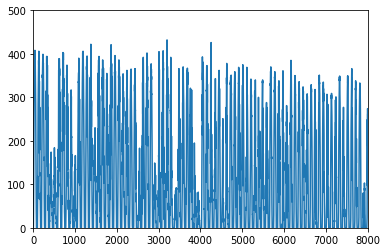

In [89]:
time_series = df['GEN_ENERGY'].values.astype('float')

for i in range(len(time_series)):
    if time_series[i] > 500:
        time_series[i] = (time_series[i-1] + time_series[i+1])/2 
        
plt.plot(time_series)
plt.xlim([0,8000])
plt.ylim([0,500])
plt.show()

# sin 예시
# interval = 50
# train_num = 1000
# time_series = np.sin(np.arange(0, 2*train_num/10, 0.1))
# input_series = np.zeros((train_num, interval, 1))
# target_series = np.zeros((train_num, interval, 1))

# for i in range(train_num):
#     input_series[i, :, 0] = time_series[i: i+interval]
#     target_series[i, :, 0] = time_series[i+interval: i+interval*2]
    
# input_series = torch.from_numpy(input_series).to(device)
# target_series = torch.from_numpy(target_series).to(device)

interval = 97

total_num = 8000
train_num = 7000
test_num = 1000

input_series = np.zeros((train_num + test_num, interval, 1))
target_series = np.zeros((train_num + test_num, interval, 1))

for i in range(train_num + test_num):
    input_series[i, :, 0] = time_series[i: i+interval]
    target_series[i, :, 0] = time_series[i+interval: i+interval*2]

input_series = torch.from_numpy(input_series).to(device)
target_series = torch.from_numpy(target_series).to(device)
    
X_train = input_series[:train_num]
X_test = input_series[train_num: train_num + test_num]
y_train = target_series[:train_num]
y_test = target_series[train_num: train_num + test_num]

In [91]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, num_layers = self.num_layers, batch_first = True)

        # Define the output layer
        self.out = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self, batch_size):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

    def forward(self, input, hidden):
        input = input.float()
        batch_size = input.shape[0]
        lstm_out, lstm_hidden = self.lstm(input, hidden)
        outs = []
        for seq in range(lstm_out.size(1)):
            outs.append(self.out(lstm_out[:, seq, :]))
        return torch.stack(outs, dim=1), lstm_hidden

/home/cwj/venv/local/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch  0 MSE:  8348.87109375
Epoch  1 MSE:  4902.998046875
Epoch  2 MSE:  3959.1240234375
Epoch  3 MSE:  3391.911376953125
Epoch  4 MSE:  3341.544189453125
Epoch  5 MSE:  3194.528564453125
Epoch  6 MSE:  3411.923828125
Epoch  7 MSE:  3853.201171875
Epoch  8 MSE:  3810.943603515625
Epoch  9 MSE:  3721.712890625
Epoch  10 MSE:  3355.773193359375
Epoch  11 MSE:  3950.875
Epoch  12 MSE:  3632.041748046875
Epoch  13 MSE:  3559.799072265625
Epoch  14 MSE:  3718.926513671875
Epoch  15 MSE:  3717.311279296875
Epoch  16 MSE:  3732.073486328125
Epoch  17 MSE:  3716.084228515625
Epoch  18 MSE:  3653.05029296875
Epoch  19 MSE:  3693.11865234375
Epoch  20 MSE:  3644.77978515625
Epoch  21 MSE:  3641.359619140625
Epoch  22 MSE:  3545.138671875
Epoch  23 MSE:  3677.28662109375
Epoch  24 MSE:  3404.089599609375
Epoch  25 MSE:  3653.62060546875
Epoch  26 MSE:  3681.961181640625
Epoch  27 MSE:  3691.780517578125
Epoch  28 MSE:  3680.35791015625
Epoch  29 MSE:  3835.483642578125
Epoch  30 MSE:  3736.72070

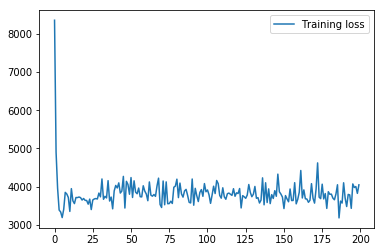

In [92]:
learning_rate = 2e-2
num_epochs = 200
input_size = 1

model = LSTM(input_dim= input_size, hidden_dim=256, output_dim=1, num_layers=2).to(device)
loss_fn = torch.nn.MSELoss(size_average=False)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


#####################
# Train model
#####################

hist = np.zeros(num_epochs)
batch_size = 200
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #loss = 0
    for b in range(int(train_num / batch_size)):
        lstm_hidden = model.init_hidden(batch_size=batch_size)
        #loss_fn = torch.nn.MSELoss(size_average=False)
        lstm_input = X_train[batch_size*b:batch_size*(b+1), :, :].view(batch_size, interval, 1)
        lstm_out, lstm_hidden = model(lstm_input, lstm_hidden)
        
        target = y_train[batch_size*b:batch_size*(b+1), :, :].float()
        loss = torch.nn.MSELoss()(lstm_out, target)        
        
        #loss += loss_fn(lstm_out, y_train[batch_size*b:batch_size*(b+1), :, :].float())    
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    if t % 1 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()
        

#####################
# Plot preds and performance
#####################
# plt.plot(lstm_out.cpu().detach().numpy(), label="Preds")
# plt.plot(y_train.cpu().detach().numpy(), label="Data")
# plt.legend()
# plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

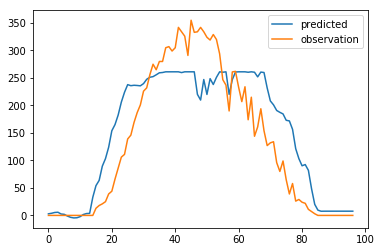

In [104]:
# Forward pass
lstm_hidden = model.init_hidden(batch_size = 1)
y_pred = model(X_train[1620:1621].view(1, interval, 1), lstm_hidden)
plt.plot(y_pred[0].cpu().detach().numpy().flatten(), label = 'predicted')
plt.plot(y_train[1620].cpu().numpy(), label = 'observation')
plt.legend()

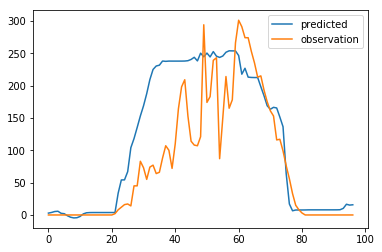

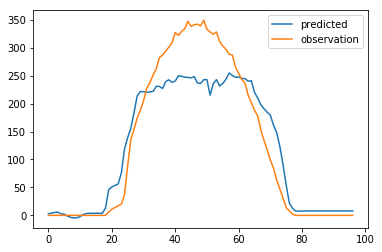

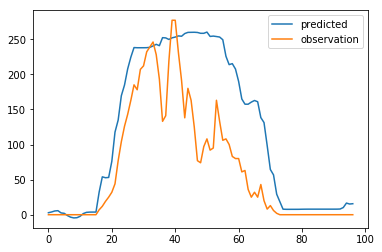

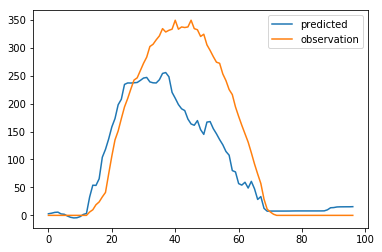

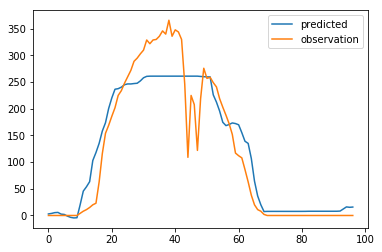

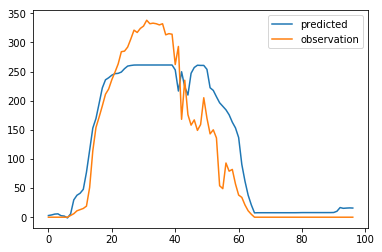

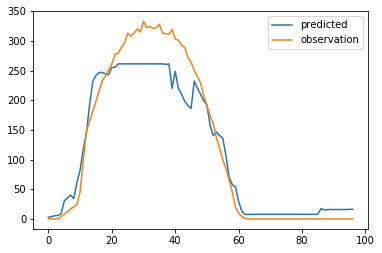

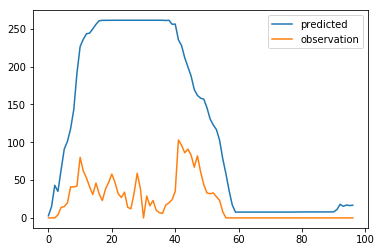

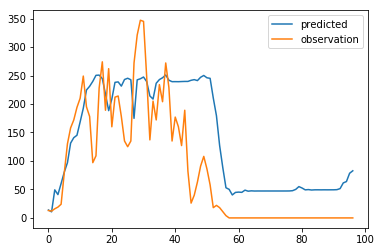

In [96]:
for i in range(9):
    lstm_hidden = model.init_hidden(batch_size = 1)
    y_pred = model(X_test[80+100*i:81+100*i].view(1, interval, 1), lstm_hidden)
    plt.plot(y_pred[0].cpu().detach().numpy().flatten(), label = 'predicted')
    plt.plot(y_test[80+100*i].cpu().numpy(), label = 'observation')
    plt.legend()
    plt.show()

In [22]:
df = df.replace(' ', 0)
df.head()

,SITE_NO,DATE,TIME,GEN_ENERGY,TEMPERATURE,SOLAR_IRRADIANCE,WIND_SPEED,MODULE_TEMPERATURE
0,SJ001,2017-09-01,05:00:00,0.0,0,0,0.2675,0
1,SJ001,2017-09-01,05:10:00,0.0,0,0,0.0720,0
2,SJ001,2017-09-01,05:20:00,0.0,0,0,0.0000,0
3,SJ001,2017-09-01,05:30:00,0.0,0,0,0.0000,0
4,SJ001,2017-09-01,05:40:00,0.0,15.5596,0,0.0000,13.8067


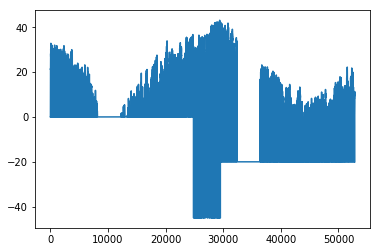

In [23]:
plt.plot(df['TEMPERATURE'].values.astype('float'))
plt.show()

In [34]:
df['DATE'][8000]

'2017-11-23'

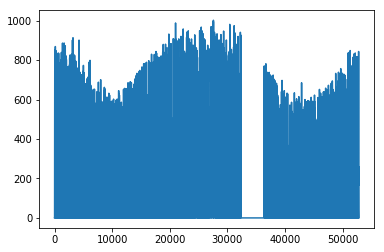

In [24]:
plt.plot(df['SOLAR_IRRADIANCE'].values.astype('float'))
plt.show()

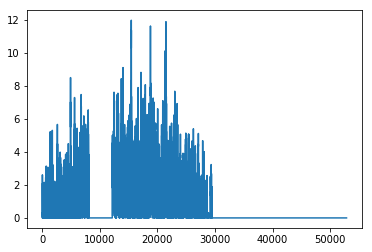

In [25]:
plt.plot(df['WIND_SPEED'].values.astype('float'))
plt.show()

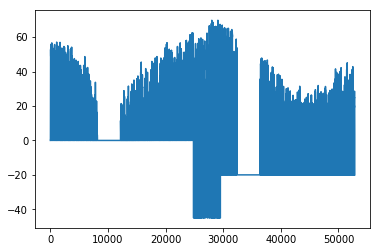

In [26]:
plt.plot(df['MODULE_TEMPERATURE'].values.astype('float'))
plt.show()